# Cleaning Data

In this notebook we start the analizing the two dataset and correct errors


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import  Path

# Taxi Dataset

We start from the taxi dataset

In [2]:
df = pd.read_csv(Path("data/Chicago_Taxi_Trips_2020_10percent.csv")) # this open the csv dataset considering the path
#print(df.head()) #first 5 lines

df.columns = [c.replace(' ', '_') for c in df.columns]  #replaces spaces in columns with underscores

In [3]:
df.shape

(342292, 23)

In [4]:
df.Trip_Start_Timestamp = pd.to_datetime(df.Trip_Start_Timestamp)
df.Trip_End_Timestamp = pd.to_datetime(df.Trip_End_Timestamp)

df = df[df.Trip_End_Timestamp > df.Trip_Start_Timestamp]

In [5]:
#TODO ci sarebbe da controllare se la durata in secondi sia la stessa della differenza fra partenza e arrivo
#df=df[(df.Trip_End_Timestamp-df.Trip_Start_Timestamp)==pd.to_timedelta(df.Trip_Seconds * 10 ** 9)]

In [6]:
df.shape

(217211, 23)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217211 entries, 1 to 342291
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Trip_ID                     217211 non-null  object        
 1   Taxi_ID                     217209 non-null  object        
 2   Trip_Start_Timestamp        217211 non-null  datetime64[ns]
 3   Trip_End_Timestamp          217211 non-null  datetime64[ns]
 4   Trip_Seconds                217170 non-null  float64       
 5   Trip_Miles                  217211 non-null  float64       
 6   Pickup_Census_Tract         98648 non-null   float64       
 7   Dropoff_Census_Tract        97899 non-null   float64       
 8   Pickup_Community_Area       202307 non-null  float64       
 9   Dropoff_Community_Area      195835 non-null  float64       
 10  Fare                        217196 non-null  float64       
 11  Tips                        217196 non-

In [8]:
df.head()

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Extras,Trip_Total,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location
1,493354c5b05333aeeb05055a4914c5d38bacef60,ca885a78545e9a44a5f365164cfbaca32fee95082b0d4f...,2020-01-01,2020-01-01 00:30:00,1200.0,5.30,NaN,NaN,8.0,23.0,...,0.0,20.10,Credit Card,Star North Management LLC,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026)
2,450f3aa6b31aa37cbb7c972f92a9ba31ab506c79,81bc2020b8536280419b3e152ad07a0c5b9f53cbb503a0...,2020-01-01,2020-01-01 00:15:00,540.0,1.70,1.703108e+10,1.703108e+10,8.0,8.0,...,0.0,8.00,Cash,Taxi Affiliation Services,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347)
3,39100cdb94f6da6b54f71f1d1cdc2ba330f97e09,a548c63608ec50e02a2311a0b6b1b2274995e3637ccb4c...,2020-01-01,2020-01-01 00:15:00,419.0,0.98,1.703128e+10,1.703184e+10,28.0,32.0,...,1.0,7.50,Cash,City Service,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
4,36bbb8cf2622b3ce7dde8f6bbaacc903a8403333,33164e16dd29b1c58cd15cce31df4bfcb75d9903cb66de...,2020-01-01,2020-01-01 00:30:00,1800.0,1.50,1.703128e+10,1.703132e+10,28.0,32.0,...,1.0,15.25,Cash,Medallion Leasin,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
5,3444c0944148777101ef56a70c02721de9e72d87,32e7d9c3c319d691d5719786a73f4c406fb5b5a68ac70c...,2020-01-01,2020-01-01 00:15:00,720.0,1.30,1.703108e+10,1.703108e+10,8.0,8.0,...,1.0,9.25,Cash,Taxi Affiliation Services,41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)


### Data preparation

We count the number of missing values for each columns

In [9]:
df.isnull().sum()

Trip_ID                            0
Taxi_ID                            2
Trip_Start_Timestamp               0
Trip_End_Timestamp                 0
Trip_Seconds                      41
Trip_Miles                         0
Pickup_Census_Tract           118563
Dropoff_Census_Tract          119312
Pickup_Community_Area          14904
Dropoff_Community_Area         21376
Fare                              15
Tips                              15
Tolls                             15
Extras                            15
Trip_Total                        15
Payment_Type                       0
Company                            0
Pickup_Centroid_Latitude       14897
Pickup_Centroid_Longitude      14897
Pickup_Centroid_Location       14897
Dropoff_Centroid_Latitude      20994
Dropoff_Centroid_Longitude     20994
Dropoff_Centroid__Location     20994
dtype: int64

Using the description given from the City of Chiacago we can assume that there is
from 23930 to 30916 trips from or for location outside Chicago.

We will remove the rows without all values:

In [10]:
df.dropna(how='all').shape

(217211, 23)

We find that the all rows has at least a correct value

### Statistics

In [11]:
from scipy.stats import median_abs_deviation #as median_abs_deviation

The following funtcion will help us to compute the statics useful to find data errors
or correct NaN value using the Winsorizing aproch with a understable approach to the correct percentile

In [12]:
def statistics(variable):
    stats = {}
    stats['mean'] = variable.mean()
    stats['std'] = variable.std()
    stats['max'] = variable.max()
    stats['min'] = variable.min()
    stats['median'] = np.nanmedian(variable)  #NANmedian invece di median
    stats['1%'] = np.nanpercentile(variable, 1)
    stats['5%'] = np.nanpercentile(variable, 5)
    stats['10%'] = np.nanpercentile(variable,10)  #NANpercentile invece di percentile
    stats['17,5%'] = np.nanpercentile(variable,17.5)
    stats['25%'] = np.nanpercentile(variable,25)  #NANpercentile invece di percentile
    stats['75%'] = np.nanpercentile(variable,75)  #NANpercentile invece di percentile
    stats['95%'] = np.nanpercentile(variable, 95)
    stats['99%'] = np.nanpercentile(variable,99)  #NANpercentile invece di percentile
    stats['99.9%'] = np.nanpercentile(variable,99.9)  #NANpercentile invece di percentile
    stats['mad'] = median_abs_deviation(variable, nan_policy = 'omit')
    return stats

starting from Trip Seconds

In [14]:
statistics(df.Trip_Seconds)

{'mean': 1151.8839848966247,
 'std': 2053.0070079368047,
 'max': 85320.0,
 'min': 4.0,
 'median': 840.0,
 '1%': 180.0,
 '5%': 296.0,
 '10%': 360.0,
 '17,5%': 442.0,
 '25%': 540.0,
 '75%': 1421.0,
 '95%': 2640.0,
 '99%': 4080.0,
 '99.9%': 33760.92900003327,
 'mad': 378.0}

We see that the maximum value of the Trip duration in seconds is 85320 seconds or, to better
understand, 23.7 hours. This not make sense and we think that is and outlier.

For this columns we consider a Winsorizing or Trimming of 5.1%:
We not consider above 99.9th percentiles because it is 13835  seconds or 3,8 hours.

We not consider below 5th percentiles because less than 60 seconds are useless trip.


-

Now the Trip Miles:

In [15]:
statistics(df.Trip_Miles)

{'mean': 5.098076294478241,
 'std': 7.048069108740239,
 'max': 980.5,
 'min': 0.0,
 'median': 2.1,
 '1%': 0.0,
 '5%': 0.0,
 '10%': 0.0,
 '17,5%': 0.5,
 '25%': 0.9,
 '75%': 7.31,
 '95%': 17.89,
 '99%': 24.69899999999994,
 '99.9%': 42.3,
 'mad': 1.8900000000000001}

We se tha max as 980 Miles more than the Miles that occure to go to New York from Chicago
So it is an outlier.

Winsorizing/Trimming of 17,6%:

below 17.5th percentile we not consider the value because is less than 0.1 Miles (0,160 km
personal case: Bovisa station - BL27 bulding is 0,4 km).
above 99.9th percentile

In [16]:
#TODO escludere gli outlier presenti in Trips Miles and Trips


In [17]:
statistics(df.Fare)

{'mean': 19.43350913460647,
 'std': 78.7837368960156,
 'max': 9004.25,
 'min': 0.0,
 'median': 11.75,
 '1%': 3.25,
 '5%': 5.25,
 '10%': 6.0,
 '17,5%': 6.75,
 '25%': 7.5,
 '75%': 26.5,
 '95%': 45.5,
 '99%': 63.5,
 '99.9%': 127.95125000000553,
 'mad': 5.5}

Winsorizing of 1,1%: exlude
below 1th percentile (that is the base Fare as write on the Chicago WebSite)
above 99.9th percentile (the higher values is probably given by the outlier value of Miles and trip)

In [18]:
statistics(df.Tips)

{'mean': 1.952361369454278,
 'std': 3.274050068834175,
 'max': 100.0,
 'min': 0.0,
 'median': 0.0,
 '1%': 0.0,
 '5%': 0.0,
 '10%': 0.0,
 '17,5%': 0.0,
 '25%': 0.0,
 '75%': 2.6,
 '95%': 9.56,
 '99%': 12.69,
 '99.9%': 20.980500000002213,
 'mad': 0.0}

 This is soggetive value of every people so i think that is better
 to only ignore above the 99.9th percentile

In [19]:
statistics(df.Tolls)

{'mean': 0.0024503674100812152,
 'std': 0.15756549289251684,
 'max': 50.0,
 'min': 0.0,
 'median': 0.0,
 '1%': 0.0,
 '5%': 0.0,
 '10%': 0.0,
 '17,5%': 0.0,
 '25%': 0.0,
 '75%': 0.0,
 '95%': 0.0,
 '99%': 0.0,
 '99.9%': 0.0,
 'mad': 0.0}

 This is influnced by the trips outside Chicago we need to reanalyze  after

In [20]:
statistics(df.Extras)

{'mean': 1.379171900034991,
 'std': 24.31411695041801,
 'max': 6644.44,
 'min': 0.0,
 'median': 0.0,
 '1%': 0.0,
 '5%': 0.0,
 '10%': 0.0,
 '17,5%': 0.0,
 '25%': 0.0,
 '75%': 1.0,
 '95%': 5.0,
 '99%': 22.25,
 '99.9%': 46.0,
 'mad': 0.0}

In [21]:
statistics(df.Trip_Total)

{'mean': 22.889823753659904,
 'std': 83.18735998682448,
 'max': 9004.25,
 'min': 0.0,
 'median': 13.3,
 '1%': 3.5,
 '5%': 5.75,
 '10%': 6.75,
 '17,5%': 8.0,
 '25%': 9.0,
 '75%': 28.5,
 '95%': 58.44,
 '99%': 82.00249999999942,
 '99.9%': 162.90250000001106,
 'mad': 5.800000000000001}

In [22]:
#solo colonne su cui ha senso fare media, mediana, ecc...
#num_features = [4,5,10,11,12,13,14]
#num_features = ['Trip_Seconds','Trip_Miles','Fare','Tips','Tolls','Extras','Trip_Total']

In [23]:
#def summarize(data, features):
    #summary = {}
    #for i in range(6):
        #summary[i] = statistics(data.iloc[:,features[i]])
    #return summary

In [24]:
#summarize(df,num_features)

### Distance Travelled

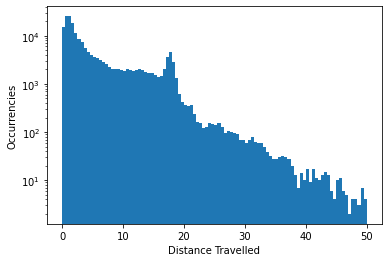

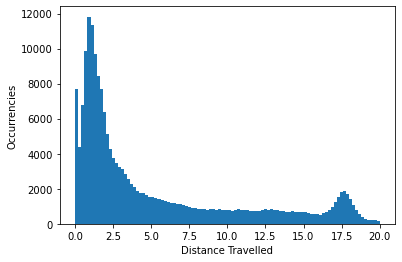

In [25]:
#limito il range nel grafico o direttamente elimino i dati sopra il 99 percentile dal database

plt.hist(df.Trip_Miles, bins = 100, range = (0.01, 50))
plt.yscale('log')   #scala logaritmica
plt.xlabel('Distance Travelled')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Trip_Miles, bins = 100, range = (0.01, 20))
plt.xlabel('Distance Travelled')
plt.ylabel('Occurrencies')
plt.show()

#### Investigo perchè ci sono tanti viaggi di 17.5 miglia

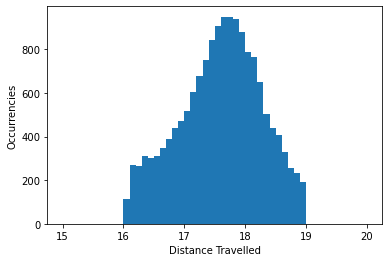

In [26]:
#isolo i viaggi tra 16 e 19 miglia
trips = df[(df.Trip_Miles > 16) & (df.Trip_Miles < 19)]

plt.hist(trips.Trip_Miles, bins = 50, range = (15, 20))
plt.xlabel('Distance Travelled')
plt.ylabel('Occurrencies')
plt.show()

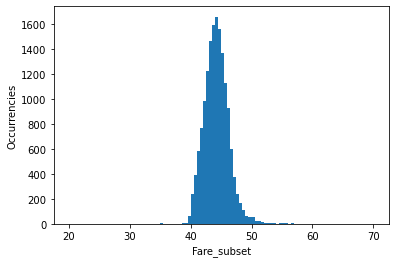

In [27]:
#visualizzo prezzo dei viaggi tra 16 e 19 miglia
plt.hist(trips.Fare, bins = 100, range = (20, 70))
plt.xlabel('Fare_subset')
plt.ylabel('Occurrencies')
plt.show()

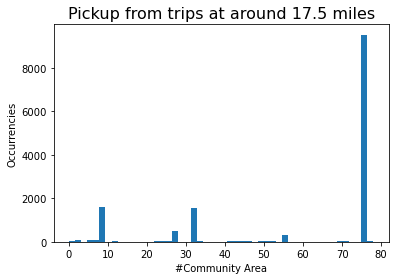

In [28]:
# molti viaggi tra 16 e 19 miglia partono da Community_Area 76 - O'Hare Airport
plt.hist(trips.Pickup_Community_Area, bins = 50, range = (0, 78))
plt.xlabel('#Community Area')
plt.ylabel('Occurrencies')
plt.title('Pickup from trips at around 17.5 miles', fontsize = 16)
plt.show()

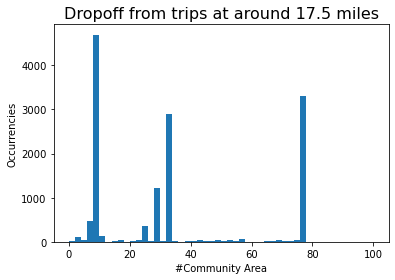

In [29]:
# molti viaggi tra 16 e 19 miglia vanno a Community_Area 8,24,28,32,76
# 8: Near North Side - 24: West Town - 28: Near West Side - 32: Loop
plt.hist(trips.Dropoff_Community_Area, bins = 50, range = (0, 100))
plt.xlabel('#Community Area')
plt.ylabel('Occurrencies')
plt.title('Dropoff from trips at around 17.5 miles', fontsize = 16)
plt.show()

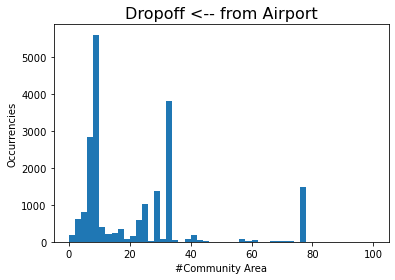

In [30]:
#isolo SOLO i viaggi che partono da Community Area 76 (aeroporto)
from_76 = df[df.Pickup_Community_Area == 76]
#plotto dove va la gente che parte dall'aeroporto
plt.hist(from_76.Dropoff_Community_Area, bins = 50, range = (0, 100))
plt.xlabel('#Community Area')
plt.ylabel('Occurrencies')
plt.title('Dropoff <-- from Airport', fontsize = 16)
plt.show()

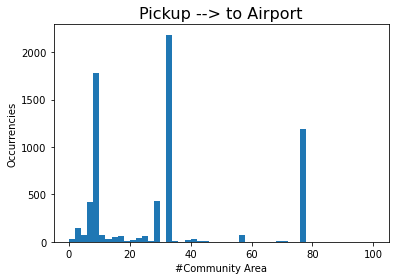

In [31]:
#isolo SOLO i viaggi che arrivano a Community Area 76 (aeroporto)
to_76 = df[df.Dropoff_Community_Area == 76]
#plotto da dove parte la gente che arriva all'aeroporto
plt.hist(to_76.Pickup_Community_Area, bins = 50, range = (0, 100))
plt.xlabel('#Community Area')
plt.ylabel('Occurrencies')
plt.title('Pickup --> to Airport', fontsize = 16)
plt.show()

### Pickup/Dropoff delle Community Areas

#### In istogramma

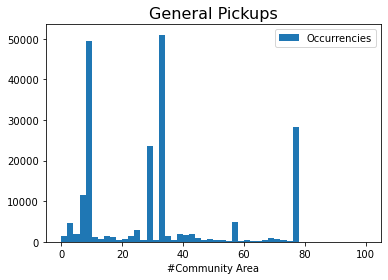

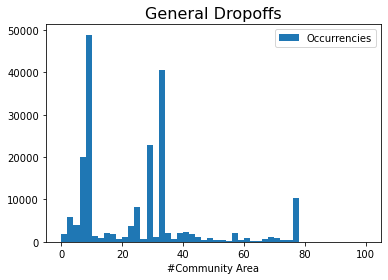

In [32]:
plt.hist(df.Pickup_Community_Area, bins = 50, range = (0, 100), label='Occurrencies')
plt.xlabel('#Community Area')
plt.title('General Pickups', fontsize = 16)
plt.legend()
plt.show()

plt.hist(df.Dropoff_Community_Area, bins = 50, range = (0, 100), label='Occurrencies')
plt.xlabel('#Community Area')
plt.title('General Dropoffs', fontsize = 16)
plt.legend()
plt.show()

#### In coordinate geografiche

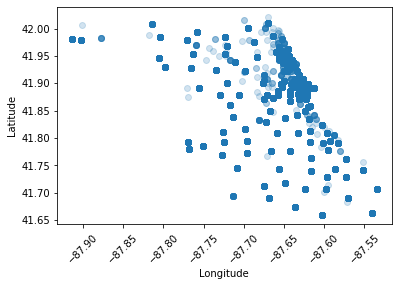

<Figure size 800x800 with 0 Axes>

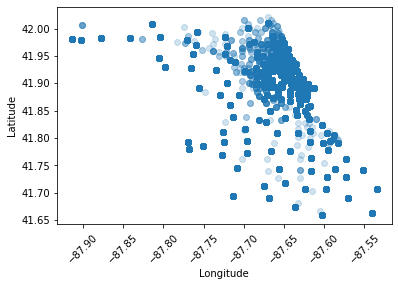

In [33]:
#Partenza
plt.scatter(df.Pickup_Centroid_Longitude, df.Pickup_Centroid_Latitude, alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks(rotation=45)
plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.show()
#Arrivo
plt.scatter(df.Dropoff_Centroid_Longitude, df.Dropoff_Centroid_Latitude, alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks(rotation=45)
plt.show()

### Trip Duration

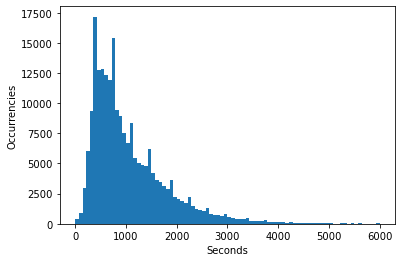

In [34]:
plt.hist(df.Trip_Seconds, bins = 84, range = (1, 6000))
#plt.yscale('log')
plt.xlabel('Seconds')
plt.ylabel('Occurrencies')
plt.show()

### Fares and Extras

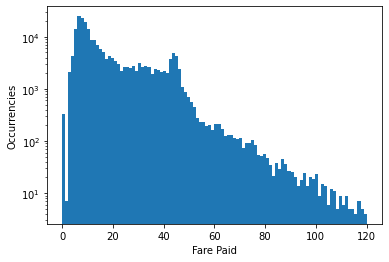

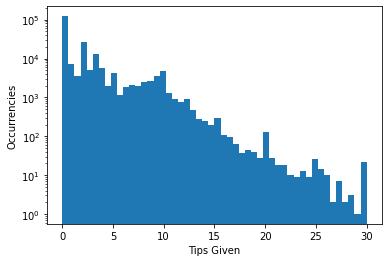

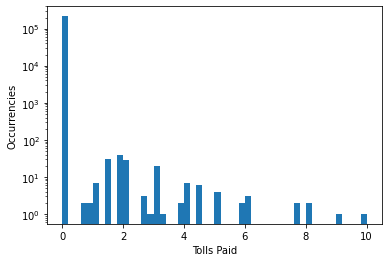

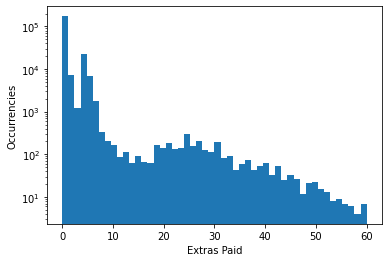

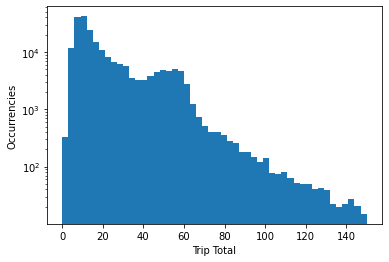

In [35]:
#scala logaritmica

plt.hist(df.Fare, bins = 100, range = (0, 120))
plt.yscale('log')
plt.xlabel('Fare Paid')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Tips, bins = 50, range = (0, 30))
plt.yscale('log')
plt.xlabel('Tips Given')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Tolls, bins = 50, range = (0, 10))
plt.yscale('log')
plt.xlabel('Tolls Paid')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Extras, bins = 50, range = (0, 60))
plt.yscale('log')
plt.xlabel('Extras Paid')
plt.ylabel('Occurrencies')
plt.show()

plt.hist(df.Trip_Total, bins = 50, range = (0, 150))
plt.yscale('log')
plt.xlabel('Trip Total')
plt.ylabel('Occurrencies')
plt.show()

### Payment Method

In [36]:
df.Payment_Type.value_counts()

Cash           95880
Credit Card    94868
Prcard         12558
Unknown         9425
Mobile          4144
No Charge        210
Dispute          111
Prepaid           15
Name: Payment_Type, dtype: int64

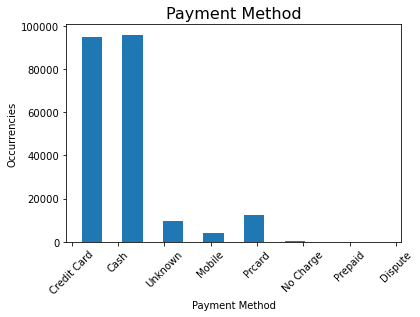

In [37]:
plt.hist(df.Payment_Type, bins = 8, rwidth=0.5)
plt.xlabel('Payment Method')
plt.ylabel('Occurrencies')
plt.title('Payment Method', fontsize = 16)
plt.xticks(rotation=45)
plt.show()

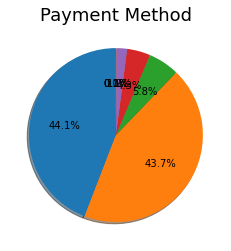

In [38]:
plt.pie(df.Payment_Type.value_counts(), shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Payment Method', fontsize=18)
#plt.legend()
plt.show()

### Timestamps (formato americano: mese-gg-anno)

In [39]:
df.Trip_Start_Timestamp = pd.to_datetime(df.Trip_Start_Timestamp)
df.Trip_Start_Timestamp

1        2020-01-01 00:00:00
2        2020-01-01 00:00:00
3        2020-01-01 00:00:00
4        2020-01-01 00:00:00
5        2020-01-01 00:00:00
                 ...        
342287   2020-09-30 23:30:00
342288   2020-09-30 23:30:00
342289   2020-09-30 23:45:00
342290   2020-09-30 23:45:00
342291   2020-10-01 00:00:00
Name: Trip_Start_Timestamp, Length: 217211, dtype: datetime64[ns]

In [40]:
df.Trip_Start_Timestamp.min()

Timestamp('2020-01-01 00:00:00')

In [41]:
df.Trip_Start_Timestamp.max()

Timestamp('2020-10-01 00:00:00')

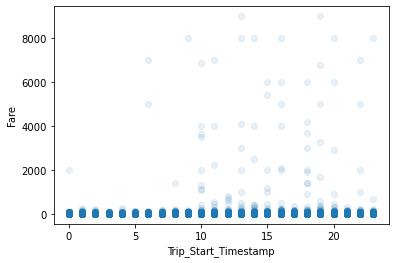

In [42]:
plt.scatter(df.Trip_Start_Timestamp.dt.hour, df.Fare, alpha = 0.1)
plt.xlabel('Trip_Start_Timestamp')
plt.ylabel('Fare')
plt.show()

### Companies

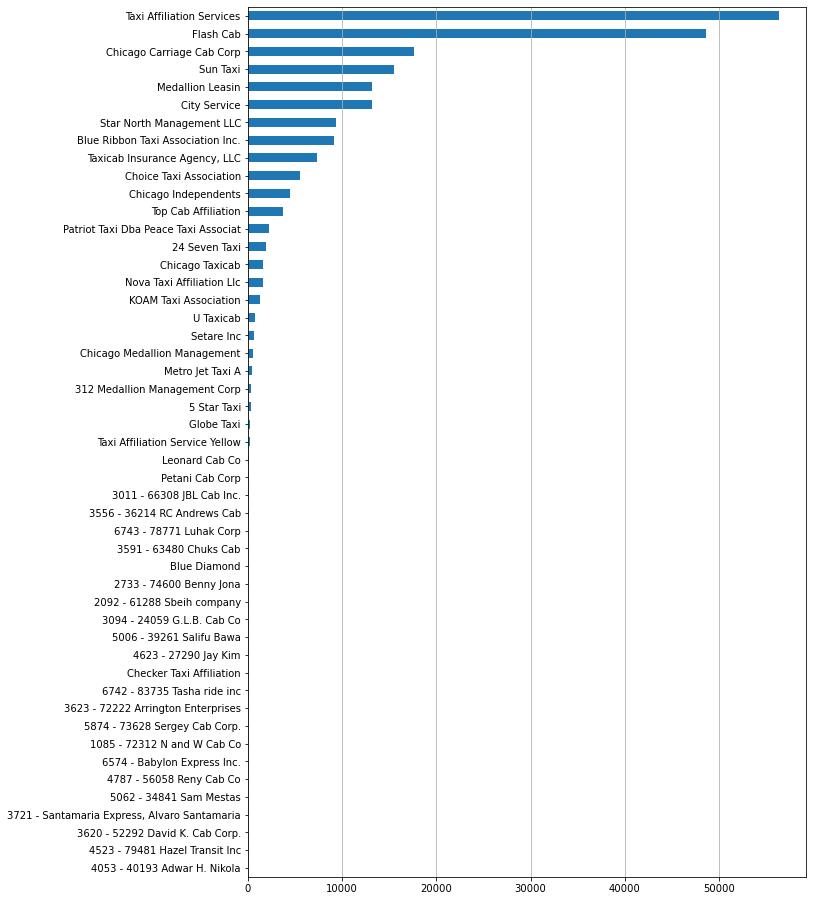

In [43]:
df.Company.value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(10,16), fontsize=10)
plt.grid(b=None, which='major', axis='x')

#### Trovo costo medio per ogni compagnia

In [44]:
#segna in un array tutti i nomi della categoria
company_names = df.Company.unique()

In [45]:
#calcola prezzo per minuto (ppm)
dollar_per_min = np.zeros(len(company_names))
for i in range(len(company_names)):  #per ogni nome...
    subset = df[df.Company == company_names[i]]
    num = subset.Trip_Total.mean()
    den = ((subset.Trip_Seconds.mean()/60))  #trip duration in minutes]
    if(den == 0):
        dollar_per_min[i] = 0
    else:
        dollar_per_min[i] = num/den

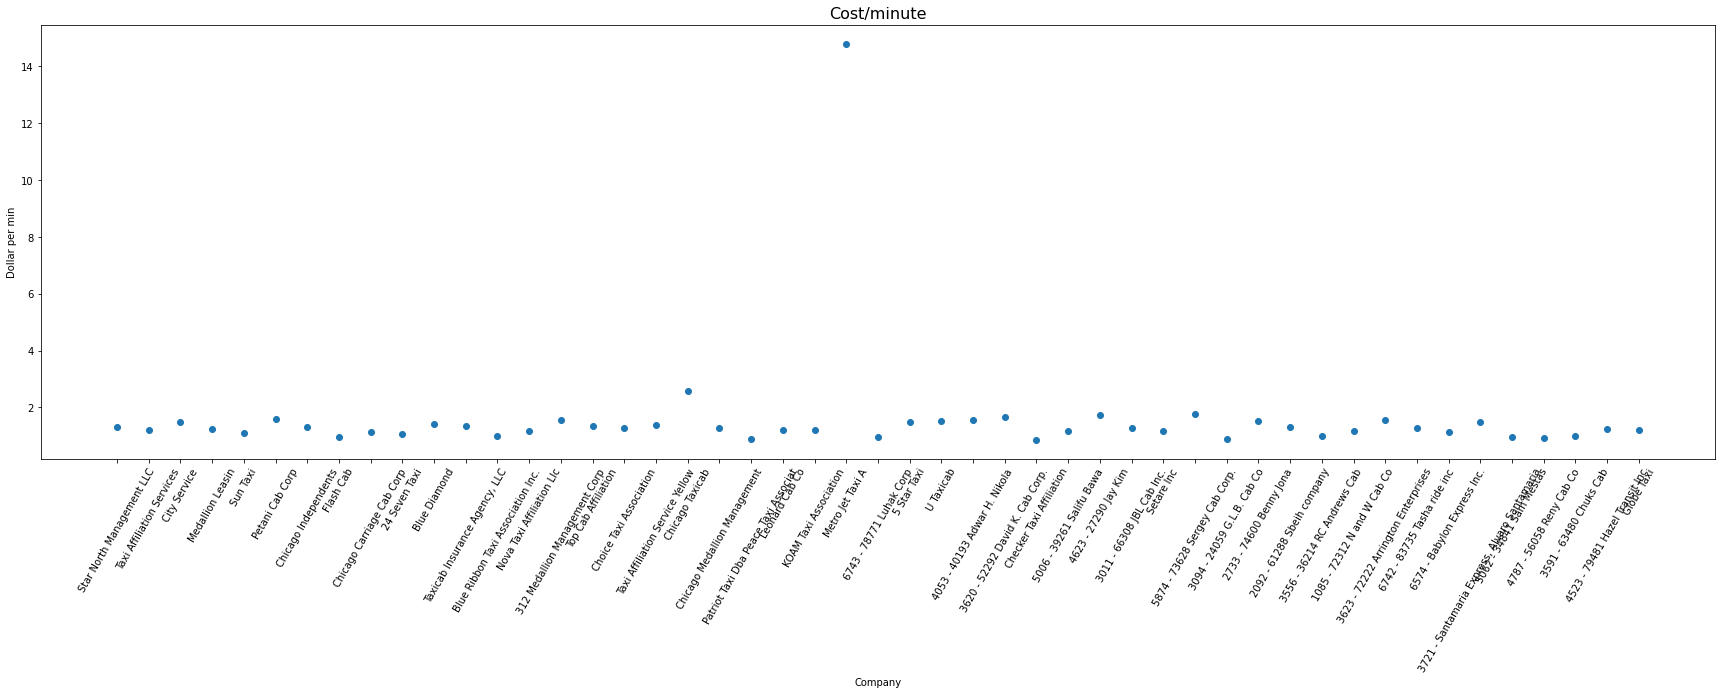

In [46]:
plt.figure(figsize=(30, 8))
plt.scatter(company_names, dollar_per_min)
plt.xlabel('Company')
plt.ylabel('Dollar per min')
plt.title('Cost/minute', fontsize = 16)
plt.xticks(rotation=60)
plt.show()

In [47]:
### Provo in modo grezzo a filtrare i dati e a plottarli

### Provo in modo grezzo a filtrare i dati e a plottarli

#### TripMiles vs. Fare

### Linea sospetta (c)

In [48]:
#Isolo la linea piccolina (non la principale)
a = df[(df.Trip_Miles < 6) & (df.Trip_Miles > 0)]
b = a[(a.Fare < 300) & (a.Fare > 20)]
c = b[((b.Trip_Miles < 1.7) | (b.Fare > 60)) & ((b.Trip_Miles < 1) | (b.Fare > 35))]  #linea "sospetta" isolata

NameError: name 'c' is not defined

In [ ]:
plt.scatter(c.Trip_Miles, c.Fare, alpha = 0.1)
plt.xlabel('Trip Miles')
plt.ylabel('Fare')
plt.show()

In [ ]:
plt.scatter(c.Pickup_Centroid_Longitude, c.Fare, alpha = 0.1)
plt.xlabel('Trip Miles')
plt.ylabel('Fare')
plt.show()

#### Duration vs. Fare

In [ ]:
#TODO
e = d[d.Trip_Seconds < 15000]
f = e[e.Trip_Seconds > 0]

plt.scatter(f.Trip_Seconds, f.Fare, alpha = 0.1)
plt.xlabel('Trip Seconds')
plt.ylabel('Fare')
plt.show()

#### TimeStart vs. Fare

In [ ]:
plt.scatter(c.Trip_Start_Timestamp.dt.hour, c.Fare, alpha = 0.1)
plt.xlabel('Trip_Start_Timestamp')
plt.ylabel('Fare')
plt.show()

In [ ]:
subset = np.isnan(df.Fare)  #controlla quanti NaN ci sono
unique, counts = np.unique(subset, return_counts=True)
unique, counts  #ritorna il numero di occorrenze